In [108]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import special, optimize, interpolate, signal, ndimage, integrate
from IPython.display import clear_output
import sys, os
from scipy import stats
cm = mpl.cm

In [109]:
# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid', 'navy', 'brown'])

# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 12, 6

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

# Utility Functions and Definitions

In [110]:
total_scan_time = 1*365*86400 # 1 year
MQS_Q = 1e6
sig_width = 1e-6

In [111]:
# Returns the mass in neV for a given frequency tuning 
def freq_to_ev(freq):
    return 4.13567e-9*freq

# Mass-coupling relation
KSVZ = 1.92
DFSZ = 0.75

def g_x(C_ag,m_a):
    return 2e-10*C_ag*m_a

# Numerically Evaluated Quantities

In [112]:
Reference_Impedance = 50 # [Ohm]

Source_Impedance = np.load('../Lossy_Solenoid/source_impedance.npy')[:, :465001]
Port_Voltage =  np.load('../Lossy_Solenoid/source_voltage.npy')[:, :465001]

Freq = Source_Impedance[0]
Omega = Freq * 2*np.pi * 1e6 # Angular Frequency in Hz

Source_Impedance = Source_Impedance[1] + 1j*Source_Impedance[2]
Port_Voltage = Port_Voltage[1] + 1j*Port_Voltage[2]

In [113]:
# Get the Source Voltage
Source_Voltage = (Source_Impedance + Reference_Impedance) / Reference_Impedance * Port_Voltage / 0.00942964
Source_Voltage = np.abs(Source_Voltage)

# Define Interpolating Functions
source_reactance_mag = interpolate.interp1d(Freq, ndimage.maximum_filter(np.abs(np.imag(Source_Impedance)), 5),
                                            kind = 'linear', fill_value = 'extrapolate')
source_reactance_sign = interpolate.interp1d(Freq, np.sign(np.imag(Source_Impedance)),
                                             kind ='nearest', fill_value = 'extrapolate')
source_resistance = interpolate.interp1d(Freq, np.real(Source_Impedance),
                                         kind = 'linear', fill_value = 'extrapolate')

source_impedance = lambda freq: 1j * source_reactance_sign(freq) * source_reactance_mag(freq) + source_resistance(freq)
source_voltage = interpolate.interp1d(Freq, Source_Voltage, kind = 'cubic', fill_value='extrapolate')

join_locs = []

# MQS Quantities

In [114]:
mqs_inductance = np.imag(Source_Impedance[0]) / Omega[0] # Henry
mqs_impedance = lambda freq: (2*np.pi*1j*1e6*freq) * mqs_inductance
mqs_source_voltage = lambda freq: np.abs(Source_Voltage[0]) * freq / Freq[0]
mqs_resistance = lambda freq: np.abs(mqs_impedance(freq)) / MQS_Q

# Quality Factors

In [115]:
Q_Res = np.abs(np.imag(source_impedance(Freq))) / (np.real(source_impedance(Freq)) + mqs_resistance(Freq))
Q_Bandwidth = np.zeros((len(Source_Impedance)))

for i in range(0, len(Source_Impedance)-1, 10):
    if i %100 == 0:
        print(i)
    
    interp_freqs = Freq[i:][::10]
    
    resonant_reactance = -np.imag(source_impedance(Freq[i]))
    if resonant_reactance < 0:
        resonant_impedance = lambda freq: 1j * resonant_reactance * Freq[i] / freq

    else:
        resonant_impedance = lambda freq: 1j * resonant_reactance * freq / Freq[i]
    
    # Transfer function and normalization
    transfer = lambda freq: 1 / (source_impedance(freq) + resonant_impedance(freq) + mqs_resistance(Freq[i]))
    norm = np.abs(transfer(Freq[i]))**2
    
    # Want to find where the transfer function is at half power
    loss = lambda freq: np.abs(transfer(freq))**2 / norm-1/2
    
    # Evaluate loss function on the grid, to get a good estimate of the half-power location
    grid_eval = loss(interp_freqs)
    locs = np.where(grid_eval < 0)[0]
    
    # If the power never drops by half, the bandwidth is very small. Take it to be 1.
    if len(locs) == 0:
        Q_Bandwidth[i] = 1
    
    # Otherwise, use the guess from the grid evaluation in a root-finding
    else:    
        bandwidth = 2*(optimize.brentq(loss, Freq[i], interp_freqs[locs[0]])-Freq[i])
        Q_Bandwidth[i] = Freq[i] / bandwidth
        
clear_output()

# Remove what we didn't evaluate
mask_locs = []
mask_locs = np.array(np.union1d(mask_locs, np.where(Q_Bandwidth==0)[0]), int)

# Explicit Integrals for Current Squared

In [86]:
eta_a = 20
to_current_units = 4.25285e-22 # eV -> A^2 / (Hz)

def thermal_noise_power(omega, R, Z, T = .02):
    '''
    omega: in units of Hz
    R: thermal resistance in units of ohms
    Z: impedance at omega in units of ohms
    T: temperature in units of K
    
    Returns power spectral density of thermal noise [dP/d\omega] in A^2 / Hz
    '''
    
    omega_nat =  4.13567e-15* omega # eV
    R_nat = 0.00265442 * R # unitless
    Z_nat = 0.00265442 * Z # unitless
    T_nat = 8.61733e-05 * T # eV
    
    # Using equation S16
    norm = 2 * omega_nat / np.pi * R_nat / Z_nat**2
    thermal_dist = 1 / (np.exp(omega_nat / T_nat) - 1) + 1/2
    
    current_psd_nat = norm * thermal_dist
    return current_psd_nat*to_current_units


def readout_noise_power(omega, omegaR, Z, ZR):
    '''
    omega: in units of Hz
    omegaR: the resonant tuning frequency in units of Hz
    Z: the impedance at omega, in units of ohms
    ZR: the impedance at resonance, in units of ohms
    
    Returns power spectral density of readout noise in [dP/d\omega] in A^2/Hz
    '''
    
    omega_nat =  4.13567e-15* omega # eV
    omegaR_nat =  4.13567e-15* omegaR # eV
    Z_nat = 0.00265442 * Z # unitless
    ZR_nat = 0.00265442 * ZR # unitless
    
    # Using equation S16
    norm = eta_a/2/np.pi * omegaR_nat / ZR_nat
    current_psd_nat = norm * ((omega_nat / omegaR_nat)**2 + (ZR_nat / Z_nat)**2)
    
    return current_psd_nat*to_current_units

# Get TS per Second

In [128]:
def OnResTS(freq, mqs = False):
    '''    
    Freq: the frequency at which the signal appears, in units of MHz
    
    Returns: the test statistic for one second of collection on resonance for specified frequencies
    assuming DFSZ coupling
    '''
    
    omega = 2*np.pi*1e6*freq # Hz
    resistance = mqs_resistance(freq)

    if mqs:
        ZR = resistance
    else:
        ZR = np.real(source_impedance(freq) + resistance)
    

    thermal_noise = thermal_noise_power(omega, resistance, ZR)
    readout_noise = readout_noise_power(omega, omega, ZR, ZR)
    total_noise = thermal_noise + readout_noise
    
    norm = 1 / (2 *np.pi) / (2*np.pi * 1e6*freq * sig_width)
    
    if mqs:
        TS = norm*mqs_source_voltage(freq)**4 / ZR**4 / (total_noise)**2

    else:
        TS = norm*source_voltage(freq)**4 / ZR**4 / (total_noise)**2

    return TS * g_x(DFSZ, freq_to_ev(freq))**4

In [129]:
def TuningTS(freq, res_freq):

    '''
    freq: the frequencies at which we evaluate the test statistic, in MHz
    res_freq: the frequency at which we tune to resonance, in MHz
    
    Returns: the test statistic for one second of collection at all specified frequencies
    for a given resonant tuning assuming DFSZ coupling
    '''
    
    omega = 2*np.pi*1e6*freq # Hz
    res_omega = 2 * np.pi * 1e6 * res_freq # Hz

    resonant_reactance = -np.imag(source_impedance(res_freq))
    
    if resonant_reactance < 0:
        resonant_impedance = lambda freq: 1j * resonant_reactance * res_freq / freq

    else:
        resonant_impedance = lambda freq: 1j * resonant_reactance * freq / res_freq
    
    resistance = mqs_resistance(freq) #ohm 
    Z = np.abs(source_impedance(freq) + resonant_impedance(freq) + resistance)
    ZR = np.abs(source_impedance(res_freq) + resonant_impedance(res_freq) + mqs_resistance(res_freq))
    
    thermal_noise = thermal_noise_power(omega, resistance, Z)
    readout_noise = readout_noise_power(omega, res_omega, Z, ZR)
    total_noise = thermal_noise + readout_noise
    
    simple_norm = 1 / (2 *np.pi) / (2*np.pi * 1e6*freq * sig_width)
    TS = simple_norm * source_voltage(freq)**4 / Z**4 / total_noise**2
    
    return TS * g_x(DFSZ, freq_to_ev(freq))**4

# Projections

In [130]:
f_MQS = 149.896 # MHz

clean_freqs = np.delete(Freq, mask_locs)
clean_q = np.delete(Q_Bandwidth, mask_locs)
interp_q = interpolate.interp1d(clean_freqs, clean_q, fill_value = 'extrapolate')

## MQS Projection

In [131]:
N_a= int(np.ceil(np.log(f_MQS / Freq[0]) / np.log(1+sig_width)))
mqs_tuning_freqs = np.geomspace(5, f_MQS, N_a)

target_ts = stats.chi2.ppf(.9, df = 1)
one_second_ts = OnResTS(mqs_tuning_freqs, mqs = True)
mqs_time_to_dfsz = target_ts/one_second_ts

# Sort and chop off low masses
sort_order = np.argsort(mqs_time_to_dfsz)

sorted_freqs = mqs_tuning_freqs[sort_order]
sorted_time = mqs_time_to_dfsz[sort_order]

sorted_time[np.searchsorted(np.cumsum(sorted_time), total_scan_time)+1:] = np.nan # Remove things that take too long
collection_time = sorted_time[np.argsort(sorted_freqs)] # Sort back to frequency ordering

# Collection test statistics 
collection_ts = one_second_ts * collection_time
mqs_sensitivity = (collection_ts / target_ts)**(.25) * g_x(DFSZ, freq_to_ev(mqs_tuning_freqs))
mqs_sensitivity = np.vstack((mqs_tuning_freqs, mqs_sensitivity))

## High Frequency Projection

In [132]:
start_freq = mqs_sensitivity[0, np.where(np.logical_not(np.isnan(mqs_sensitivity[1])))[0][0]]

hf_tuning_freqs = np.array([start_freq])

while hf_tuning_freqs[-1] < f_MQS:
    next_freq = hf_tuning_freqs[-1] * (1 + np.maximum(sig_width, 1/interp_q(hf_tuning_freqs[-1])))
    hf_tuning_freqs = np.append(hf_tuning_freqs, next_freq)
    if len(hf_tuning_freqs) % 10000 == 0:
        clear_output()
    if len(hf_tuning_freqs) % 100 == 0:
        print(hf_tuning_freqs[-1])
        
clear_output()

In [133]:
hf_collection_time = np.interp(hf_tuning_freqs, mqs_tuning_freqs, collection_time)
hf_collection_time *= np.maximum(1, 1e6 / interp_q(hf_tuning_freqs))

In [134]:
one_second_ts = OnResTS(hf_tuning_freqs)
collection_ts = one_second_ts * hf_collection_time

# Stack for plotting
hf_sensitivity = (target_ts / collection_ts)**(.25) * g_x(DFSZ, freq_to_ev(hf_tuning_freqs))
hf_sensitivity = np.vstack((hf_tuning_freqs, hf_sensitivity))

# Mask inductive tunings
nan_locs = np.where(np.imag(source_impedance(hf_tuning_freqs)) < 0)[0]
hf_sensitivity[1, nan_locs] = np.nan

In [135]:
strategy = np.delete(np.vstack((hf_tuning_freqs, hf_collection_time)), nan_locs, axis = 1) 
np.save('../Results/Solenoid/Multipole/Strategy_'+str(eta_a)+'.npy', strategy)

# Get Sensitivity Freqs

In [124]:
save_path = '../Results/Solenoid/Multipole/Sensitivity_Freqs.npy'
if not os.path.isfile(save_path):

    f_min = 5
    f_max = 466.40568517314

    tuning_freqs = [f_min]

    counter = 0

    while tuning_freqs[-1] < f_max:
        if counter % 10000 == 0:
            clear_output()

        if counter % 1000 == 0:
            print(counter, tuning_freqs[-1])

        next_freq = (1+min(1e-3, np.maximum(sig_width, 1/interp_q(tuning_freqs[-1]))))*tuning_freqs[-1]
        tuning_freqs.append(next_freq)

        counter += 1

    tuning_freqs = np.array(tuning_freqs)
    np.save(save_path, tuning_freqs)
    
sensitivity_freqs = np.load(save_path)
clear_output()

## Load Multipole

In [125]:
#multipole_ts = np.load('../Results/Lossier_Toroid/Multipole/Eta'+str(eta_a) + '_TS.npy')
#multipole_sensitivity = (target_ts / multipole_ts)**(.25) * g_x(DFSZ, freq_to_ev(sensitivity_freqs))
#hf_multipole = np.vstack((sensitivity_freqs, multipole_sensitivity))

/var/folders/ll/j2dr6mcs2p710rlsd0zwngr40000gn/T/ipykernel_31203/2473602952.py:79: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrBr").copy()
  cols.set_under('w') # Set lowest color to white


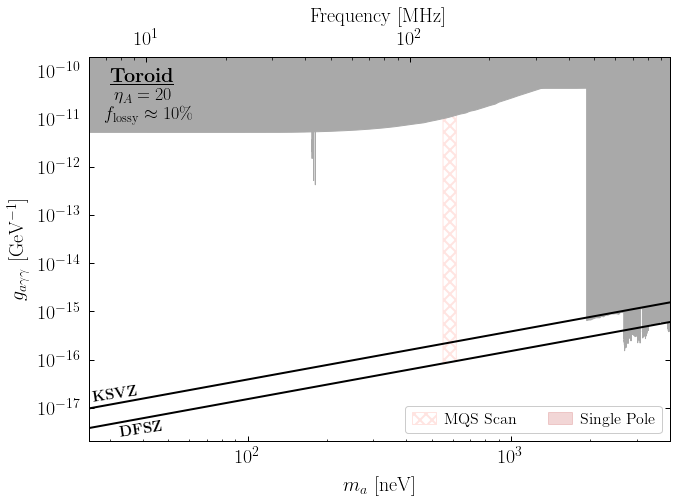

In [126]:
mpl.rcParams['figure.figsize'] = 9.5, 6
mpl.rcParams['hatch.linewidth'] = 1  # previous svg hatch linewidth
mpl.rc('hatch', color='k', linewidth=2)

fig, axs = plt.subplots()

axs.fill_between(1e9 * freq_to_ev(mqs_sensitivity[0])[::100], mqs_sensitivity[1][::100],
                 np.ones_like(mqs_sensitivity[1])[::100], color = 'mistyrose', alpha = 1,
                 zorder = 0, hatch = 'xx', facecolor = 'None', label = 'MQS Scan')

axs.fill_between(1e9 * freq_to_ev(hf_sensitivity[0])[::100], hf_sensitivity[1][::100],
                 np.ones_like(hf_sensitivity[1])[::100], color = 'indianred', alpha = .25,
                 zorder = 2, label = 'Single Pole')

#axs.plot(1e9*freq_to_ev(hf_multipole[0])[::100], ndimage.gaussian_filter(hf_multipole[1], 101)[::100],
#         color = 'maroon', label = 'Multipole')

 
#axs.fill_between(1e9 * freq_to_ev(extra_time_sensitivity[0])[::100], extra_time_sensitivity[1][::100],
#                 extra_time_sensitivity[2][::100], color = 'firebrick', alpha = .5,
#                 zorder = 2, label = 'Second Year Scan')

#axs.fill_between(1e9 * freq_to_ev(hf_year_sensitivity[0])[::100], hf_year_sensitivity[1][::100],
#                 np.ones_like(hf_year_sensitivity[1][::100]), color = 'maroon', alpha = .75, zorder =2,
#                 label = 'Third Year Scan')
        
###########################
###   Plot Formatting   ###
###########################
axs.axhspan(6.67e-11, 1e-7, color = 'darkgrey', zorder = 10)
axs.set_xlim(25, 4e3)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylabel('$g_{a \gamma \gamma}$ [GeV$^{-1}$]')

plt.tight_layout()

axs.set_ylim(2e-18, 2e-10)
#axs.set_yticks([1e-17, 1e-15, 1e-13, 1e-11], minor = True)
#axs.set_yticklabels([], minor = True)


ax2 = axs.twiny()
ax2.set_xlim(np.array(axs.get_xlim()) * 241799 / 1e6)
ax2.set_xscale('log')
ax2.set_xlabel('Frequency [MHz]')

######################
###   Adornments   ###
######################

C_logwidth=10
cmap='YlOrBr'
C_center=1
C_width=0.8
vmax = 0.9


## QCD Axion band:
g_min,g_max = 1e-18, 1e-14
m_min,m_max = np.array(axs.get_xlim()) / 1e9

# Mass-coupling relation
def g_x(C_ag,m_a):
    return 2e-10*C_ag*m_a

KSVZ = 1.92
DFSZ = 0.75

# Plot Band
n = 200
g = np.logspace(np.log10(g_min),np.log10(g_max),n)
m = np.logspace(np.log10(m_min),np.log10(m_max),n)
QCD = np.zeros(shape=(n,n))
for i in range(0,n):
    QCD[:,i] = stats.norm.pdf(np.log10(g)-np.log10(g_x(C_center,m[i])),0.0,C_width)
cols = cm.get_cmap(cmap)

cols.set_under('w') # Set lowest color to white
vmin = np.amax(QCD)/(C_logwidth/4.6)


axs.plot(1e9*m, g_x(DFSZ,m),'-',linewidth=2, color = 'black', zorder = np.inf)
axs.plot(1e9*m, g_x(KSVZ,m),'-',linewidth=2, color = 'black', zorder = np.inf)

#axs.contourf(1e9*m, g, QCD, 50,cmap=cols,vmin=vmin,vmax=vmax,zorder=0)


path = '../../AxionLimits/limit_data/AxionPhoton/'
for item in os.listdir(path):
    if '.txt' in item:
        
        if 'equals' in item:
            continue
    
        limit = np.loadtxt(path + item).T

            
        if 'MWD' not in item and 'ADMX' not in item:
            continue
        
        axs.fill_between(1e9*limit[0], limit[1], 6.7e-11* np.ones_like(limit[0]),
                         color = 'darkgrey', zorder = 5, alpha = 1)

        
        #print(np.amin(limit[0]))


#axs.axvline(freq_to_ev(5)*1e9)
axs.set_yticks([1e-17, 1e-15, 1e-13, 1e-11], minor = True)
axs.set_yticklabels([], minor = True)
legend = axs.legend(ncol = 3, fontsize = 16, loc = 'lower right')

#order = [1,2,0]
#handles, labels = axs.get_legend_handles_labels()
#print(labels)
#axs.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#           ncol = 3, fontsize = 16, loc = 'lower right')


axs.set_xlabel('$m_a$ [neV]')
axs.text(2.55e1, 1.325e-17, r'\textbf{KSVZ}', fontsize = 15, rotation = 8.5)
axs.text(3.25e1, 2.5e-18, r'\textbf{DFSZ}', fontsize = 15, rotation = 8.5)
#axs.text(4.5e1, 7.2e-11, r'\textbf{CAST}', fontsize = 15, rotation = 0, zorder = np.inf)
#axs.text(2.7e1, 7e-12, r'\textbf{MWD Polarization}', fontsize = 15, rotation = 0, zorder = np.inf)
#axs.text(2e3, 1e-15, r'\textbf{ADMX}', fontsize = 15, rotation = 8.5, zorder = np.inf)
#axs.annotate(r'\textbf{ADMX}', (170, 5e-13), (3.1e1, 1e-13), fontsize = 15,
#             arrowprops=dict(color='black', lw=1.5), ha='left', linespacing = 2.)
#axs.text(3.1e1, 5e-14, r'\textbf{SLIC}', fontsize = 15)
axs.text(30, 6e-11, r'\underline{\textbf{Toroid}}',
         fontsize = 20, zorder = np.inf, )
axs.text(40, 2.5e-11, r'$\eta_A = '+str(eta_a)+'$', fontsize = 18, zorder = np.inf, ha = 'center')
axs.text(42, 1.e-11, r'$f_\mathrm{lossy} \approx 10\%$', fontsize = 18, zorder = np.inf, ha = 'center')
#plt.savefig('../Plots/Solenoid_Projection_Eta' + str(eta_a)+'.pdf')
plt.show()